**Learner Name: Damian Najera**

# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Network to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

## Importing necessary libraries

In [91]:
import os
import numpy as np                                                                             # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer
# Display images using OpenCV
#from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
import random
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [92]:
# Load the image file of dataset
images = np.load('images.npy')

# Load the labels file of dataset
labels = pd.read_csv('Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [93]:
print(images.shape)  # For the image data
print(labels.shape)  # For the label data

(4750, 128, 128, 3)
(4750, 1)


## Exploratory Data Analysis

### Plotting random images from each of the class

In [94]:
def plot_images(images, labels):
  num_classes = 10  # Number of Classes
  categories = np.unique(labels)
  rows = 3  # Defining number of rows=3
  cols = 4  # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))  # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))  # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)  # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])  # Plotting the image
          ax.set_title(labels['Label'].iloc[random_index])
  plt.show()


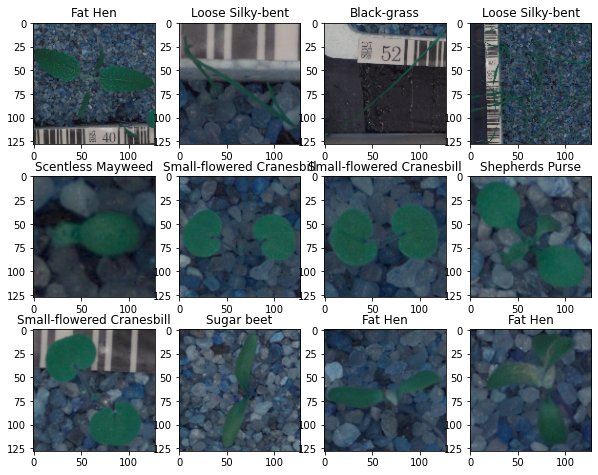

In [95]:
plot_images(images, labels)

### Checking the distribution of the target variable

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

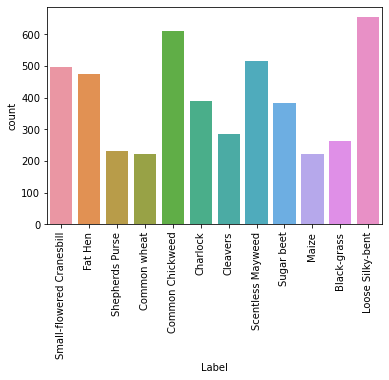

In [96]:
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')

## Data Pre-Processing

### Converting the BGR images to RGB images.

In [97]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resizing images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [98]:
# Resizing the images from 128x128 to 64x64
images_decreased = []
height = 64  # Define the height as 64
width = 64   # Define the width as 64
dimensions = (width, height)

for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))


**Image before resizing**

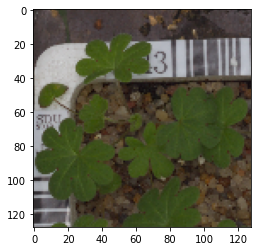

In [99]:
plt.imshow(images[3])

**Image after resizing**

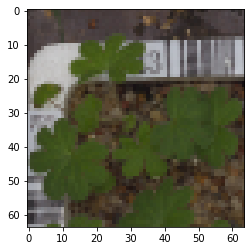

In [100]:
plt.imshow(images_decreased[3])

### Data Preparation for Modeling


- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [101]:
# Split the data with test_size as 0.1 to create the test set
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased), labels, test_size=0.1, random_state=42, stratify=labels)

# Split the remaining data with test_size as 0.1111 to create the validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42, stratify=y_temp)


In [102]:
print("Total:", len(images_decreased))
print("Training set:", len(X_train))
print("Validation set:", len(X_val))
print("Test set:", len(X_test))


Total: 4750
Training set: 3800
Validation set: 475
Test set: 475


### Encoding the target labels

In [103]:
# Initialize the LabelBinarizer
enc = LabelBinarizer()

# Fit and transform y_train, and transform y_val and y_test
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded = enc.transform(y_val)
y_test_encoded = enc.transform(y_test)

In [104]:
# Check the shape of train, validation, and test data
y_train_encoded.shape, y_val_encoded.shape, y_test_encoded.shape

((3800, 12), (475, 12), (475, 12))

#### Observations: 
- y_train_encoded​: 38473847 samples, each with 12 binary columns (one per class).
- y_val_encodedyval_encoded​: 428428 samples, each with 12 binary columns.
- y_test_encodedytest_encoded​: 475475 samples, each with 12 binary columns.

### Data Normalization

Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [105]:
# Normalize the image pixels of train, test, and validation data
X_train_normalized = np.array(X_train).astype('float32')/255.0
X_val_normalized = np.array(X_val).astype('float32')/255.0
X_test_normalized = np.array(X_test).astype('float32')/255.0

## Model Building

In [106]:
# Clearing backend
backend.clear_session()

In [107]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [108]:
# Initialize a sequential model
model1 = Sequential()

# Add the first conv layer with 128 filters and kernel size 3x3, padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Add the max pooling to reduce the size of output of the first conv layer
model1.add(MaxPooling2D((2, 2), padding='same'))

# Create two similar convolution and max-pooling layers activation = relu
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding='same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding='same'))

# Flatten the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Add a fully connected dense layer with 16 neurons
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.3))

# Add the output layer with 12 neurons and activation function as softmax since this is a multi-class classification problem
model1.add(Dense(12, activation='softmax'))

# Use the Adam Optimizer
opt = Adam()

# Compile the model using suitable metric for loss function
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

<b> Fitting the model on the train data

In [109]:
# Check the shape of your arrays
print("Shape of X_train_normalized:", X_train_normalized.shape)
print("Shape of y_train_encoded:", y_train_encoded.shape)


Shape of X_train_normalized: (3800, 64, 64, 3)
Shape of y_train_encoded: (3800, 12)


In [110]:
# Fit the model on train and also using the validation data for validation
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,  # Training data
            epochs=30,
            validation_data=(X_val_normalized, y_val_encoded),  # Validation data
            batch_size=32,
            verbose=2
)


Epoch 1/30
119/119 - 12s - loss: 2.4342 - accuracy: 0.1305 - val_loss: 2.2451 - val_accuracy: 0.2884 - 12s/epoch - 103ms/step
Epoch 2/30
119/119 - 12s - loss: 2.1589 - accuracy: 0.2774 - val_loss: 1.9455 - val_accuracy: 0.3811 - 12s/epoch - 98ms/step
Epoch 3/30
119/119 - 12s - loss: 1.9770 - accuracy: 0.3203 - val_loss: 1.7556 - val_accuracy: 0.4379 - 12s/epoch - 99ms/step
Epoch 4/30
119/119 - 12s - loss: 1.8656 - accuracy: 0.3437 - val_loss: 1.7150 - val_accuracy: 0.4526 - 12s/epoch - 97ms/step
Epoch 5/30
119/119 - 12s - loss: 1.7758 - accuracy: 0.3626 - val_loss: 1.5939 - val_accuracy: 0.4821 - 12s/epoch - 98ms/step
Epoch 6/30
119/119 - 12s - loss: 1.7701 - accuracy: 0.3461 - val_loss: 1.5842 - val_accuracy: 0.4632 - 12s/epoch - 98ms/step
Epoch 7/30
119/119 - 12s - loss: 1.6753 - accuracy: 0.3729 - val_loss: 1.4702 - val_accuracy: 0.5053 - 12s/epoch - 97ms/step
Epoch 8/30
119/119 - 12s - loss: 1.6390 - accuracy: 0.4005 - val_loss: 1.3906 - val_accuracy: 0.5326 - 12s/epoch - 97ms/step

**Model Evaluation**

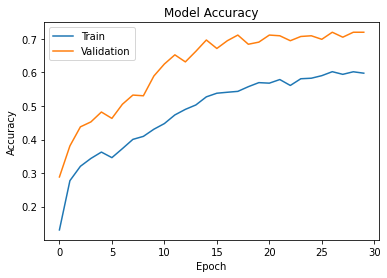

In [111]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate the model on test data**

In [112]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.9805 - accuracy: 0.7179 - 355ms/epoch - 24ms/step


**Plotting the Confusion Matrix**

In [113]:
y_pred = model1.predict(X_test_normalized)

15/15 [==============================] - 0s 23ms/step


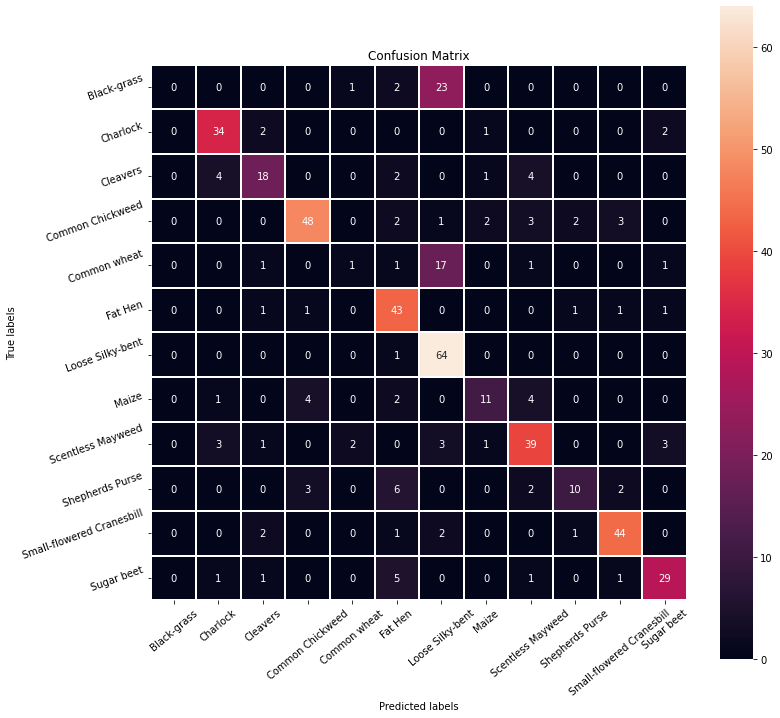

In [114]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

**Plotting Classification Report**

In [115]:
from sklearn import metrics

# Generate the classification report
cr = metrics.classification_report(y_test_arg, y_pred_arg, target_names=enc.classes_)

# Print the classification report
print(cr)

                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        26
                 Charlock       0.79      0.87      0.83        39
                 Cleavers       0.69      0.62      0.65        29
         Common Chickweed       0.86      0.79      0.82        61
             Common wheat       0.25      0.05      0.08        22
                  Fat Hen       0.66      0.90      0.76        48
         Loose Silky-bent       0.58      0.98      0.73        65
                    Maize       0.69      0.50      0.58        22
        Scentless Mayweed       0.72      0.75      0.74        52
          Shepherds Purse       0.71      0.43      0.54        23
Small-flowered Cranesbill       0.86      0.88      0.87        50
               Sugar beet       0.81      0.76      0.78        38

                 accuracy                           0.72       475
                macro avg       0.64      0.63      0.62    

#### Observations:
- The overall accuracy of the model on the test set is 72%72%. This means that the model correctly predicts the class label 72% of the time.
- The model performs particularly well on classes like "Common Chickweed", "Fat Hen", "Loose Silky-bent", "Scentless Mayweed", "Small-flowered Cranesbill", and "Sugar beet" as indicated by relatively high F1-scores.
- "Black-grass" and "Common wheat" have notably poor performance, with F1-scores of 0.000.00 and 0.080.08 respectively, indicating that the model struggles to correctly identify these classes.
- For "Loose Silky-bent", the recall is extremely high (0.98), but the precision is comparatively lower (0.58). This means the model is identifying most of the actual "Loose Silky-bent" instances but is also misclassifying other instances as "Loose Silky-bent" (False Positives).
- "Shepherds Purse" demonstrates a high precision (0.71) but a much lower recall (0.43), indicating that while the model's predictions for this class are generally accurate, it is missing a significant portion of actual instances (False Negatives).

## Model Performance Improvement

**Reducing the Learning Rate:**

**ReduceLRonPlateau()** is a function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [116]:
# Code to monitor val_accuracy
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)


### **Data Augmentation**

In [117]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [118]:
train_datagen = ImageDataGenerator(rotation_range=20, fill_mode='nearest')

In [119]:
# Initializing a sequential model
model2 = Sequential()

# Adding the first conv layer with 64 filters and kernel size 3x3, padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))

# Additional conv layer and pooling
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())

# Flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 16 neurons
model2.add(Dense(16, activation='relu'))

# Adding dropout with dropout_rate=0.3
model2.add(Dropout(0.3))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

# Initializing Adam Optimizer
opt = Adam()

# Compiling the model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

<b> Fitting the model on the train data

In [120]:
# Fitting the model on train data with batch_size=64 and epochs=30
# Epochs
epochs = 30
# Batch size
batch_size = 64

history = model2.fit(train_datagen.flow(X_train_normalized, y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                     epochs=epochs,
                     steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                     validation_data=(X_val_normalized, y_val_encoded),
                     verbose=1, callbacks=[learning_rate_reduction])


Epoch 1/30
59/59 [==============================] - 6s 98ms/step - loss: 2.2036 - accuracy: 0.2131 - val_loss: 2.4137 - val_accuracy: 0.1705 - lr: 0.0010
Epoch 2/30
59/59 [==============================] - 6s 95ms/step - loss: 1.7491 - accuracy: 0.3820 - val_loss: 2.3078 - val_accuracy: 0.2653 - lr: 0.0010
Epoch 3/30
59/59 [==============================] - 6s 95ms/step - loss: 1.5900 - accuracy: 0.4114 - val_loss: 2.1851 - val_accuracy: 0.2821 - lr: 0.0010
Epoch 4/30
59/59 [==============================] - 6s 95ms/step - loss: 1.4764 - accuracy: 0.4687 - val_loss: 2.1346 - val_accuracy: 0.4021 - lr: 0.0010
Epoch 5/30
59/59 [==============================] - 6s 96ms/step - loss: 1.3660 - accuracy: 0.5182 - val_loss: 1.9591 - val_accuracy: 0.3284 - lr: 0.0010
Epoch 6/30
59/59 [==============================] - 6s 96ms/step - loss: 1.3042 - accuracy: 0.5455 - val_loss: 1.7600 - val_accuracy: 0.5579 - lr: 0.0010
Epoch 7/30
59/59 [==============================] - 6s 96ms/step - loss: 1.2

**Model Evaluation**

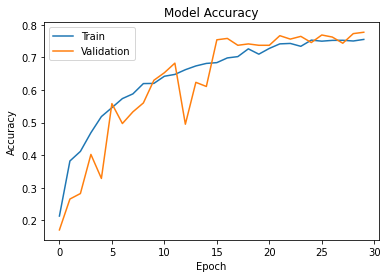

In [121]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate the model on test data**

In [122]:
# Evaluating the model on test data
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)  

15/15 - 0s - loss: 0.7422 - accuracy: 0.7874 - 159ms/epoch - 11ms/step


**Plotting the Confusion Matrix**

In [123]:
# Obtain the output probabilities
y_pred = model2.predict(X_test_normalized)

15/15 [==============================] - 0s 9ms/step


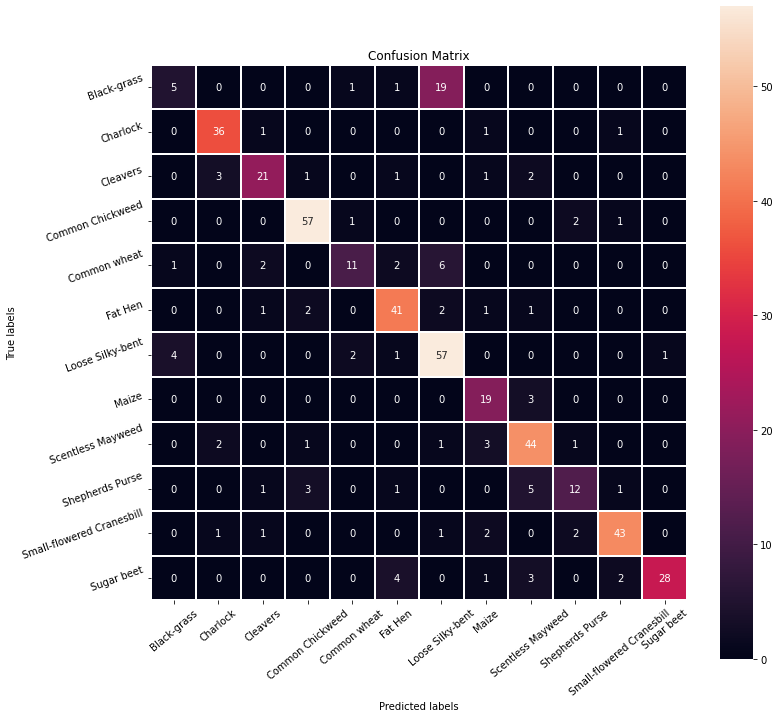

In [124]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

**Plotting Classification Report**

In [125]:
# Plotting the classification report
cr = metrics.classification_report(y_test_arg, y_pred_arg)     
print(cr)

              precision    recall  f1-score   support

           0       0.50      0.19      0.28        26
           1       0.86      0.92      0.89        39
           2       0.78      0.72      0.75        29
           3       0.89      0.93      0.91        61
           4       0.73      0.50      0.59        22
           5       0.80      0.85      0.83        48
           6       0.66      0.88      0.75        65
           7       0.68      0.86      0.76        22
           8       0.76      0.85      0.80        52
           9       0.71      0.52      0.60        23
          10       0.90      0.86      0.88        50
          11       0.97      0.74      0.84        38

    accuracy                           0.79       475
   macro avg       0.77      0.74      0.74       475
weighted avg       0.79      0.79      0.78       475



#### Observations:
- The model has an accuracy of 79%, meaning it predicted the correct class for 79% of the test samples.
- This class has a low recall (0.19) and a low precision (0.50), which indicates that the model is struggling to correctly identify and predict this class. This could be due to the class being under-represented, or the features not being distinct enough for the model to learn effectively.
- While the recall for this class is quite high (0.88), indicating that the model is identifying most actual instances of this class, the precision is slightly lower (0.66). This suggests that the model might be misclassifying other species as Loose Silky-bent, which is worth investigating further.
- This class has a high precision (0.97) but a comparatively lower recall (0.74), implying that while the predictions for Sugar beet are highly accurate, the model is failing to identify all actual instances of this class.
- Classes 1, 3, 10, and 11 (Charlock, Common Chickweed, Small-flowered Cranesbill, and Sugar beet respectively) have high precision, indicating that when the model predicts these classes, it is usually correct.
- Classes 3, 5, 6, 7, and 8 (Common Chickweed, Fat Hen, Loose Silky-bent, Maize, and Scentless Mayweed respectively) show high recall, meaning the model is able to identify most instances of these classes in the test set.
- Some classes, like Black-grass (Class 0) and Common wheat (Class 4), have both low precision and low recall, indicating that the model is both failing to identify and accurately predict these classes. This could be due to insufficient or non-representative training data for these classes, or it could point to these classes being inherently harder to distinguish based on the features used.

## Final Model

#### Model 1:
- Architecture:
  - 3 convolutional layers (128, 64, and 32 filters respectively) followed by max-pooling layers.
  - A flatten layer followed by a dense layer with 16 neurons, a dropout layer, and an output layer with 12 neurons.
- Performance:
  - Accuracy: 71.79%
#### Model 2:
- Architecture:
  - 2 convolutional layers (64 and 32 filters) followed by max-pooling layers and a batch normalization layer.
  - A flatten layer, a dense layer with 16 neurons, a dropout layer, and an output layer with 12 neurons.
  - Used data augmentation (rotation) and a learning rate reduction strategy.
- Performance:
  - Accuracy: 79%

#### Comparison:
- Model 1 uses more filters in the initial layers compared to Model 2.
- Only Model 2 incorporated data augmentation and dynamically adjusted the learning rate during training, which can help in better generalization and potentially faster convergence.
- Model 2 (79%) outperforms Model 1 (71.79%) in terms of overall accuracy on the test data.
- Model 2’s class-wise performance details reveal specific areas (classes) where the model excels or struggles, whereas we do not have such detailed insights for Model 1.
- Despite having fewer filters in the initial convolutional layers, Model 2 demonstrates superior performance, highlighting that a more complex model (Model 1) doesn’t always yield better results.
- Model 2, with its data augmentation and learning rate adjustment, potentially offers better robustness and generalization as it is exposed to more varied data during training and can adapt its learning process.

Model 2, with its higher accuracy and incorporation of data augmentation and learning rate adjustment, seems to be the more proficient model.

### Visualizing the prediction

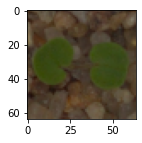

1/1 [==============================] - 0s 15ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


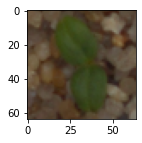

1/1 [==============================] - 0s 13ms/step
Predicted Label ['Cleavers']
True Label Cleavers


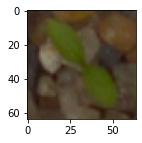

1/1 [==============================] - 0s 12ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


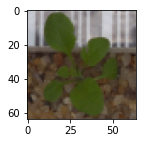

1/1 [==============================] - 0s 16ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [126]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
# Predicting the test data using model2
print('Predicted Label', enc.inverse_transform(model2.predict(X_test_normalized[2].reshape(1,64,64,3))))   
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
# Predicting the test data using model2
print('Predicted Label', enc.inverse_transform(model2.predict(X_test_normalized[33].reshape(1,64,64,3))))  
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              

plt.figure(figsize=(2,2))
plt.imshow(X_test[59],)
plt.show()
# Predicting the test data using model2
print('Predicted Label', enc.inverse_transform(model2.predict(X_test_normalized[59].reshape(1,64,64,3))))  
print('True Label', enc.inverse_transform(y_test_encoded)[59])                                              

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
# Predicting the test data using model2
print('Predicted Label', enc.inverse_transform(model2.predict(X_test_normalized[36].reshape(1,64,64,3))))  
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              

## Actionable Insights and Business Recommendations

#### Actionable Insights
- There is variability in the model’s performance across different classes, which indicates potential areas for improvement and further tuning.
- Some classes are misclassified more frequently, which might be a result of limited data or lack of distinctive features between certain classe.
- The transition from the first to the second model introduced additional complexity but also resulted in performance improvement, suggesting that more sophisticated architectures could be beneficial.
- Model 2 shows a promising performance and could be considered for deployment in a practical scenario with further refinement and testing.
- As new data becomes available or as plant species evolve, the model will need to adapt and learn from new instances to stay accurate and relevant.

#### Business Recommendations:
- Implement extensive data augmentation and gather additional data, especially for classes with lower precision and recall, to enhance the model's learning and generalization capabilities.
- Begin pilot testing of Model 2 in real-world scenarios while continuing to refine and enhance its predictive capabilities based on continuous feedback and data accumulation.
- Initiate the development of a user-friendly interface, such as a mobile application or a web platform, that allows users to interact with the model, receive predictions, and provide feedback in a streamlined manner.
- Establish a system for model updating and continuous learning that allows it to adapt to new data and evolving plant species and conditions.
- Ensure that the deployment architecture is scalable to accommodate larger data and user bases and adhere to stringent data protection and security protocols.
- Engage with agricultural experts, farmers, and agronomists to validate model outputs, gain insights into practical utility, and enhance the model’s alignment with actual field challenges and requirements.
- Provide educational resources and support to farmers and stakeholders to optimize the use of the technology, ensuring they can leverage the AI model effectively to enhance their agricultural practices.

_____